<font color=red><h1> 1. Loading data and packages</h1></font>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpl
from sklearn.cluster import KMeans
import mplfinance as mpf
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

In [65]:
data=pd.read_excel("D:/New Me/python-folder/SP500 Index.xlsx")
data=data[(data.Dates>='2020-01-01') & (data.Dates<='2022-01-01')]

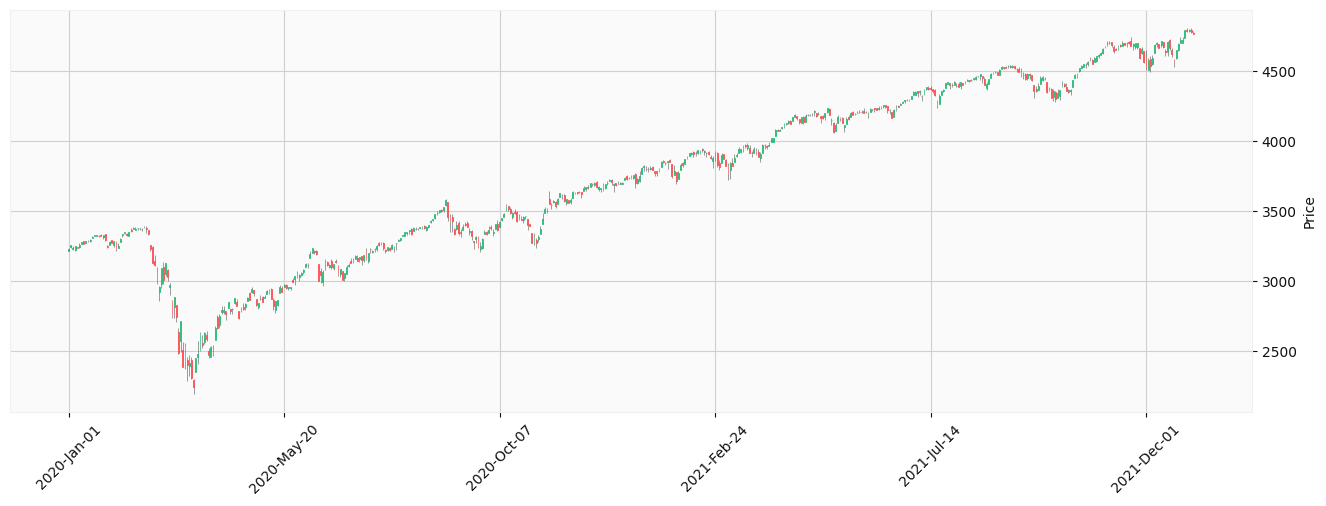

In [66]:
mpf.plot(data.set_index('Dates').loc[:,['Low','High','Open','Close','Volume']], type='candle', style='yahoo',title='',figratio=(15, 5))

<font color=red><h1> 2. Kmeans</h1></font>

In [67]:
#Specify the lookback for the exponential moving average
lookback=50
Ema=data.Close.ewm(span=lookback,adjust=False).mean()
#Calculate log returns
log_returns=np.diff(np.log(Ema))
#Fit Kmeans and set number of clusters to 3: Downtrend, Range, Uptrend
kmeans=KMeans(n_clusters=3,random_state=42)
#Store the clustre of each point
labels=kmeans.fit_predict(log_returns.reshape(-1,1))

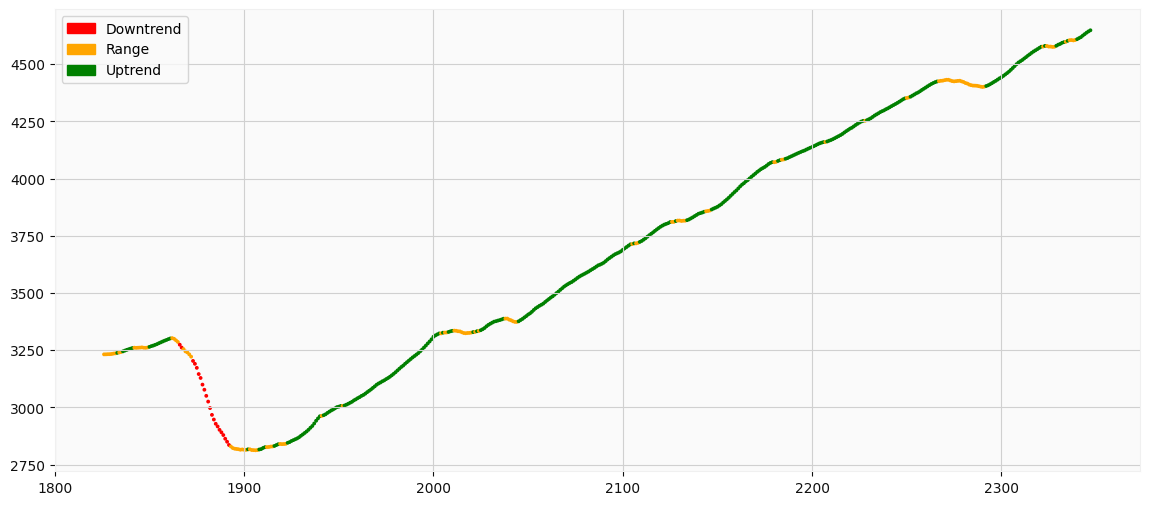

In [68]:
#Sort centers of clusters
v=sorted(enumerate(kmeans.cluster_centers_.flatten()),key=lambda x:x[1])

#Store new labels
labels_kmeans = np.zeros(len(labels),dtype=int)
for i, (j, _) in enumerate(v):
		labels_kmeans[labels == j] = i

data1=pd.DataFrame({'Ema':Ema,'Cluster':labels_kmeans},index=data.index[1:])

color_map = {0: 'red', 1: 'orange', 2: 'green'}
colors1 = data1['Cluster'].map(color_map)

plt.figure(figsize=(14, 6))
plt.scatter(data1.index,data1.Ema, c=colors1, s=3)


legend_handles = [
    mpatches.Patch(color=color_map[0], label='Downtrend'),
    mpatches.Patch(color=color_map[1], label='Range'),
    mpatches.Patch(color=color_map[2], label='Uptrend'),
]
plt.legend(handles=legend_handles)

<font color=red><h1> 3. Regression</h1></font>

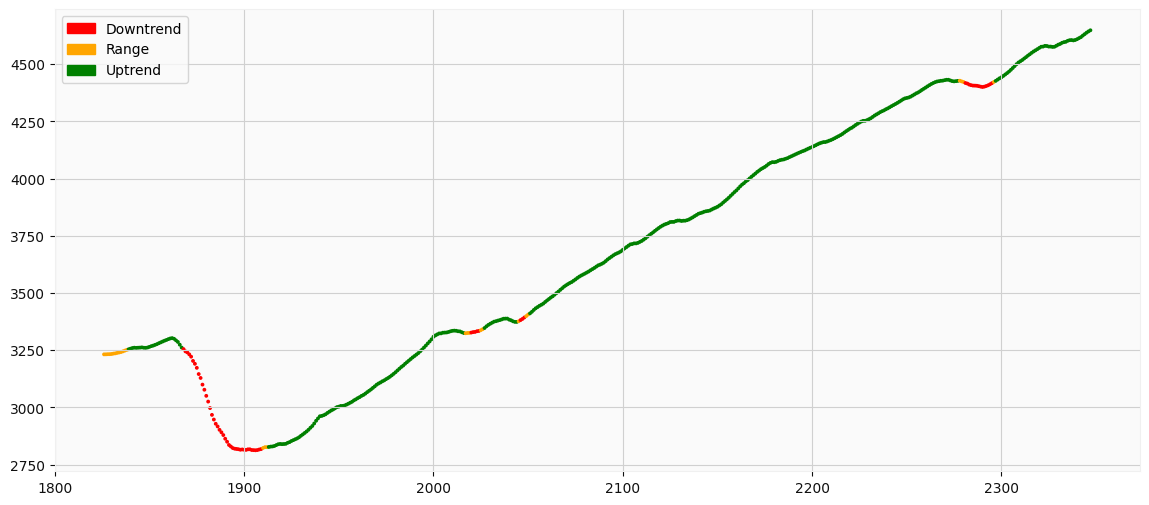

In [69]:
#Fit linear regression and get the slope
def linear_regression(y):
    model = LinearRegression()
    model.fit(np.arange(len(y)).reshape(-1,1), y)
    return(model.coef_[0])

#Set the lookback period to fit a regression
lookback2=14
t=Ema.rolling(lookback2).apply(linear_regression, raw=True)
labels_regression=np.ones(len(data)-1,dtype=int)

#uptrend_slope is the minimum slope required to consider a trend as an uptrend
uptrend_slope=0.5
#downtrend_slope is the maximum slope required to consider a trend as a downtrend
downtrend_slope=-0.2
for i in range(len(labels_regression)):
    # If the slope > uptrend_slope, then the assigned cluster is 2 (Uptrend)
    if t.values[i]>uptrend_slope:
        labels_regression[i]=2
    # If the slope < downtrend_slope, then the assigned cluster is 0 (Downtrend)
    if t.values[i]<downtrend_slope:
        labels_regression[i]=0
    # Otherwise, the assigned cluster is 1 (Range: default)

data2=pd.DataFrame({'Ema':Ema,'Cluster':labels_regression},index=data.index[1:])

color_map = {0: 'red', 1: 'orange', 2: 'green'}
colors2 = data2['Cluster'].map(color_map)

plt.figure(figsize=(14, 6))
legend_handles = [
    mpatches.Patch(color=color_map[0], label='Downtrend'),
    mpatches.Patch(color=color_map[1], label='Range'),
    mpatches.Patch(color=color_map[2], label='Uptrend'),
]
plt.legend(handles=legend_handles)

plt.scatter(data2.index,data2.Ema, c=colors2, s=3)
